In [1]:
import numpy as np
train_npz_file = np.load('../data/processed/train.npz')
X_train, y_train = train_npz_file['arr_0'], train_npz_file['arr_1']

In [2]:
X_train.shape, y_train.shape

((19280, 105, 105), (19280, 3))

In [3]:
X_train = X_train.reshape(X_train.shape[0], 105, 105, 1)
X_train.shape

(19280, 105, 105, 1)

In [4]:
np.unique(y_train[:, 2])

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20'], dtype='<U41')

Have an idea for a structure that constructs the type of dataset we want.  Create a dictionary with keys being the indices of the data, say.  

For each of these, we maintain a 2d tuple
- first element of this tuple is an array of indices of other (different) elements of the X, y.
- the second element of the tuple is another array.  the element of this is 0 or 1 depending on whether the corresponding element of the first array of the tuple is a different or the same character as the current key of the dictionary.

Then creating batches should be quite easy. And the size of the dictionary should control the corresponding size of the "dataset".  Accessing the structure to create batches should be fast and easy and we are just putting together access indices for X to form "pairs" and putting out the corresponding similarity labels.  

We could further embelish with some random transformations of the corresponding X at the batch level.  See how this goes.  Let's get the bare-bones up and going first.

In [5]:
import numpy as np
import pandas as pd

class BatchSampler:
    """
    Creates a batch sampler from raw-ish data pairs X, y.  The data needed for
    training a siamese networks are image pairs from X and binary indicators
    indicating whether they are equal.  Instead of forming these pairs explicitly,
    this sampler creates a dictionary with keys corresponding to the rows of X.
    The item stored at each key consists of a tuple with:
        - a list of indices of rows of X to pair with the current key
        - item a list of binary indicators inidcating whether they are of the same 
          type.
    Although this takes a while to initialize (as initialization calls this pair
    forming operation), this results in fairly efficient data storage, access and 
    batch construction.
    
    Attributes (this should probably be the actual attributes, not the entries
    to __init__, which should be in the document there)
    ----------
    X : array
        an n * h * w * n_channels array containing images, presumably from the 
        dataset we want to generate batches for (presumably for a siamese net
        training task).
    y : array
        an n * 3 array containing the specifics of the characters in X.  The
        columns are 'Alphabet', 'Character', 'Drawer'.  This makes this class
        quite specific to omniglot.
    batch_size : integer
        this represents the size of the batches we ultimately want to generate.
    half_expand_factor : integer
        this represents half of the size by which we would like to expand the
        dataset, or half of the number of pairs we would like to construct for
        each row of X.
        
    Methods
    -------
    form_pairs() 
        forms the dictionary (this should probably be a private method as it is 
        called on initialization and not meant to be used.  Then it doesn't enter 
        into the docstring here or possibly at all).
    
    This is the general idea for forming these docstrings.  Description then 
    outline Attributes and public Methods.  Functions inside then have regular
    style docstrings.  
    
    The way sampling is done here means we probably end up passing the same pairs
    in here and there, but hopefully this won't hold things up too much.  
    """
    
    
    def __init__(self, X, y, batch_size=64, half_expand_factor=4):
        self.X = X
        self.y_n_pd = y # think on whether we really need this for what we want
        self.y = pd.DataFrame(
                        data=y,
                        columns=['Alphabet', 'Character', 'Drawer']
                    )
        self.B = batch_size
        self.E = half_expand_factor
        self.n = y.shape[0]
        self.pairs = self.form_pairs()
        self.inds = np.random.permutation(y.shape[0])
        self.current_batch = 0
        self.current_efactor = 0
        self.max_batches = 1 + y.shape[0] // batch_size
        
    def form_pairs(self):
        pairs = {}
        for i in range(self.n):
            al, ch, dr = self.y.iloc[i]
            same_inds = self.y[
                    (self.y.Alphabet == al) &
                    (self.y.Character == ch) &
                    (self.y.Drawer != dr)
                ].sample(self.E, replace=False).index.values
            diff_inds = self.y[
                   ~((self.y.Alphabet == al) &
                     (self.y.Character == ch))
                ].sample(self.E, replace=False).index.values
            curr_y = np.zeros(2 * self.E)
            curr_y[:self.E] = 1
            p = np.random.permutation(2 * self.E)
            pairs[i] = (
                    np.concatenate((same_inds, diff_inds))[p],
                    curr_y[p]
                )
        return pairs
    
    def generate_batch(self):
        """
        Needs to be written.
        """
        current_inds = self.inds[
                    range(
                        self.current_batch * self.B, 
                        min((1 + self.current_batch) * self.B, self.n)
                    )
        ]
        X_b_inds, y_b = [], []
        for ind in current_inds:
            X_b_inds.append((ind, self.pairs[ind][0][self.current_efactor]))
            y_b.append(self.pairs[ind][1][self.current_efactor])
        X_b_inds = np.array(X_b_inds)
        self.current_batch = (1 + self.current_batch) % self.max_batches
        if self.current_batch == 0:
            self.current_efactor = (1 + self.current_efactor) % (2 * self.E)
        return (
                (self.X[X_b_inds[:, 0],:], 
                 self.X[X_b_inds[:, 1],:]), 
                np.array(y_b)
            )
    
    def generate_one_shot(self, n=20):
        """
        Although this could also be a class that subclasses this.
        """
        alphabet = np.random.choice(self.y.Alphabet.unique())
        drawers = np.random.choice(
                        self.y.Drawer.unique(), 
                        2, replace=False
                    )
        characters = np.random.choice(
                        self.y[
                            self.y.Alphabet == alphabet
                        ].Character.unique(),
                        n, replace=False
                    )
        
        test_inds = self.y[
                        (self.y.Alphabet == alphabet) &
                        (self.y.Drawer == drawers[0]) &
                        np.isin(self.y.Character, characters)
                    ].index.values
        
        train_inds = self.y[
                        (self.y.Alphabet == alphabet) &
                        (self.y.Drawer == drawers[1]) &
                        np.isin(self.y.Character, characters)
                    ].index.values
        return (
                    (test_inds, train_inds), 
                    (self.y.iloc[test_inds], 
                     self.y.iloc[train_inds])
        )

Might change the name of this class to something like OneShotData, and have it do all the things we are interested in.  

Another thing to do would be to have the option of caching a number of one-shot tasks for speed, so that we don't have to do the random sampling every time we call generate_one_shot on the object, as this is quite slow.  

Or this might be easier with a separate OneShot generator.  

The other thing that needs to be done is we need to build something that we can pass to a Bayesian optimization method...  Training is fast enough that we should be able to pick out something quite good in the next couple of days by optimizing on a couple of simple things like learning_rate and dropout rate by layer.  

Looks like a pandas data frame is quite a useful way to store the labels array for the sampling tasks that we require.  

In [6]:
class OneShotGenerator:
    """
    A class that generates one-shot tasks.  It does this in two
    ways.  
    - Caches a number of one-shot tasks and cycles through these.
      this is the default mode.
    - Randomly generates a one-shot task.  This is the mode that 
      should be used on test data, but is a little slow for the 
      purposes of model evaluation during training.
    Also, the default is an 10-way one-shot task, because this
    will be used on the training data, which has some alphabets
    which have a small number of characters (I think 11 or 12 is
    the smallest).  All alphabets in the test set have at least
    20 characters, so 20-way evaluation here is fine.  
        We could also default to 20-way and if an alphabet only
    has m < 20 characters, then we fall back on an m-way challenge.
    This might actually be better.  
    """
    def __init__(self, X, y, mode='cached', n_way=20, cache_size=320):
        self.X = X
        self.y_n_pd = y # think on whether we really need this for what we want
        self.y = pd.DataFrame(
                        data=y,
                        columns=['Alphabet', 'Character', 'Drawer']
                    )
        self.mode = mode
        self.n_way = n_way
        self.cache_size = cache_size
        self.cache = {}
        self.form_cache()
    
        self.n = y.shape[0]
        self.current_task_number = 0
        
    def form_one_shot(self):
        """
        Although this could also be a class that subclasses this.
        """
        alphabet = np.random.choice(self.y.Alphabet.unique())
        # make sure that the number of tasks that we don't attempt
        # to generate an n-way task when the alphabet is too small.
        n = min(
                self.n_way,
                self.y.Character[
                    self.y.Alphabet == alphabet
                ].unique().shape[0]
            )
        
        drawers = np.random.choice(
                        self.y.Drawer.unique(), 
                        2, replace=False
                    )
        characters = np.random.choice(
                        self.y[
                            self.y.Alphabet == alphabet
                        ].Character.unique(),
                        n, replace=False
                    )
        
        test_inds = self.y[
                        (self.y.Alphabet == alphabet) &
                        (self.y.Drawer == drawers[0]) &
                        np.isin(self.y.Character, characters)
                    ].index.values
        
        train_inds = self.y[
                        (self.y.Alphabet == alphabet) &
                        (self.y.Drawer == drawers[1]) &
                        np.isin(self.y.Character, characters)
                    ].index.values
        return (
                    (test_inds, train_inds), 
                    (self.y.iloc[test_inds], 
                     self.y.iloc[train_inds])
        )
    
    def form_cache(self):
        for i in range(self.cache_size):
            self.cache[i] = self.form_one_shot()
           
    def generate_one_shot(self):
        if self.mode == 'cached':
            current_one_shot = self.cache[self.current_task_number]
            self.current_task_number = (
                    (1 + self.current_task_number) % self.cache_size
                ) 
            return current_one_shot
        return self.form_one_shot()

In [7]:
y_train_pd = pd.DataFrame(data=y_train, columns=['Alphabet', 'Character', 'Drawer'])

In [8]:
al_sample = np.random.choice(y_train_pd.Alphabet.unique())

In [9]:
y_train_pd[np.isin(y_train_pd.Alphabet, al_sample)].sample(5, replace=False)

,Alphabet,Character,Drawer
17441,Cyrillic,character20,18
17785,Cyrillic,character24,13
17596,Cyrillic,character28,20
17646,Cyrillic,character03,03
17473,Cyrillic,character27,07


In [10]:
y_train_pd[(y_train_pd.Alphabet == al_sample) & 
           (y_train_pd.Character == 'character07')].sample(2, replace=False)

,Alphabet,Character,Drawer
17943,Cyrillic,character07,13
17948,Cyrillic,character07,14


In [11]:
a = y_train_pd[(y_train_pd.Alphabet == al_sample) &
           ((y_train_pd.Drawer == '13') | 
            (y_train_pd.Drawer == '12'))].sample(20, replace=False)

In [12]:
a.index

Int64Index([17591, 17472, 17914, 17739, 17419, 17432, 17736, 18032, 17615,
            17633, 17933, 17934, 17648, 17594, 17885, 17572, 17551, 17857,
            17475, 17940],
           dtype='int64')

In [13]:
y_train_pd.shape[0]

19280

In [14]:
a, b, c = y_train_pd.iloc[0]

In [15]:
a, b, c

('Gujarati', 'character42', '14')

In [16]:
al, ch, dr = y_train_pd.iloc[5]

In [17]:
al, ch, dr

('Gujarati', 'character42', '16')

In [18]:
y_train_pd[(y_train_pd.Alphabet == al) &
           (y_train_pd.Character == ch) &
           (y_train_pd.Drawer != dr)].sample(4, replace=False).index.values

array([ 8, 12,  3,  0])

In [19]:
y_train_pd[~((y_train_pd.Alphabet == al) &
            (y_train_pd.Character == ch))].sample(4, replace=False).index.values

array([ 5790,  8971, 10339,   270])

In [20]:
a = BatchSampler(
        X_train[:2500],
        y_train[:2500],
        batch_size=7,
        half_expand_factor=2
)

In [21]:
(b, c), d = a.generate_batch()
a.current_batch, a.current_efactor, b.shape, c.shape, d

(1, 0, (7, 105, 105, 1), (7, 105, 105, 1), array([0., 1., 0., 1., 1., 1., 0.]))

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [23]:
def plot_tick_free_axis(ax, im):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.imshow(1 - im, cmap='Greys')

[0. 1. 0. 1. 1. 1. 0.]


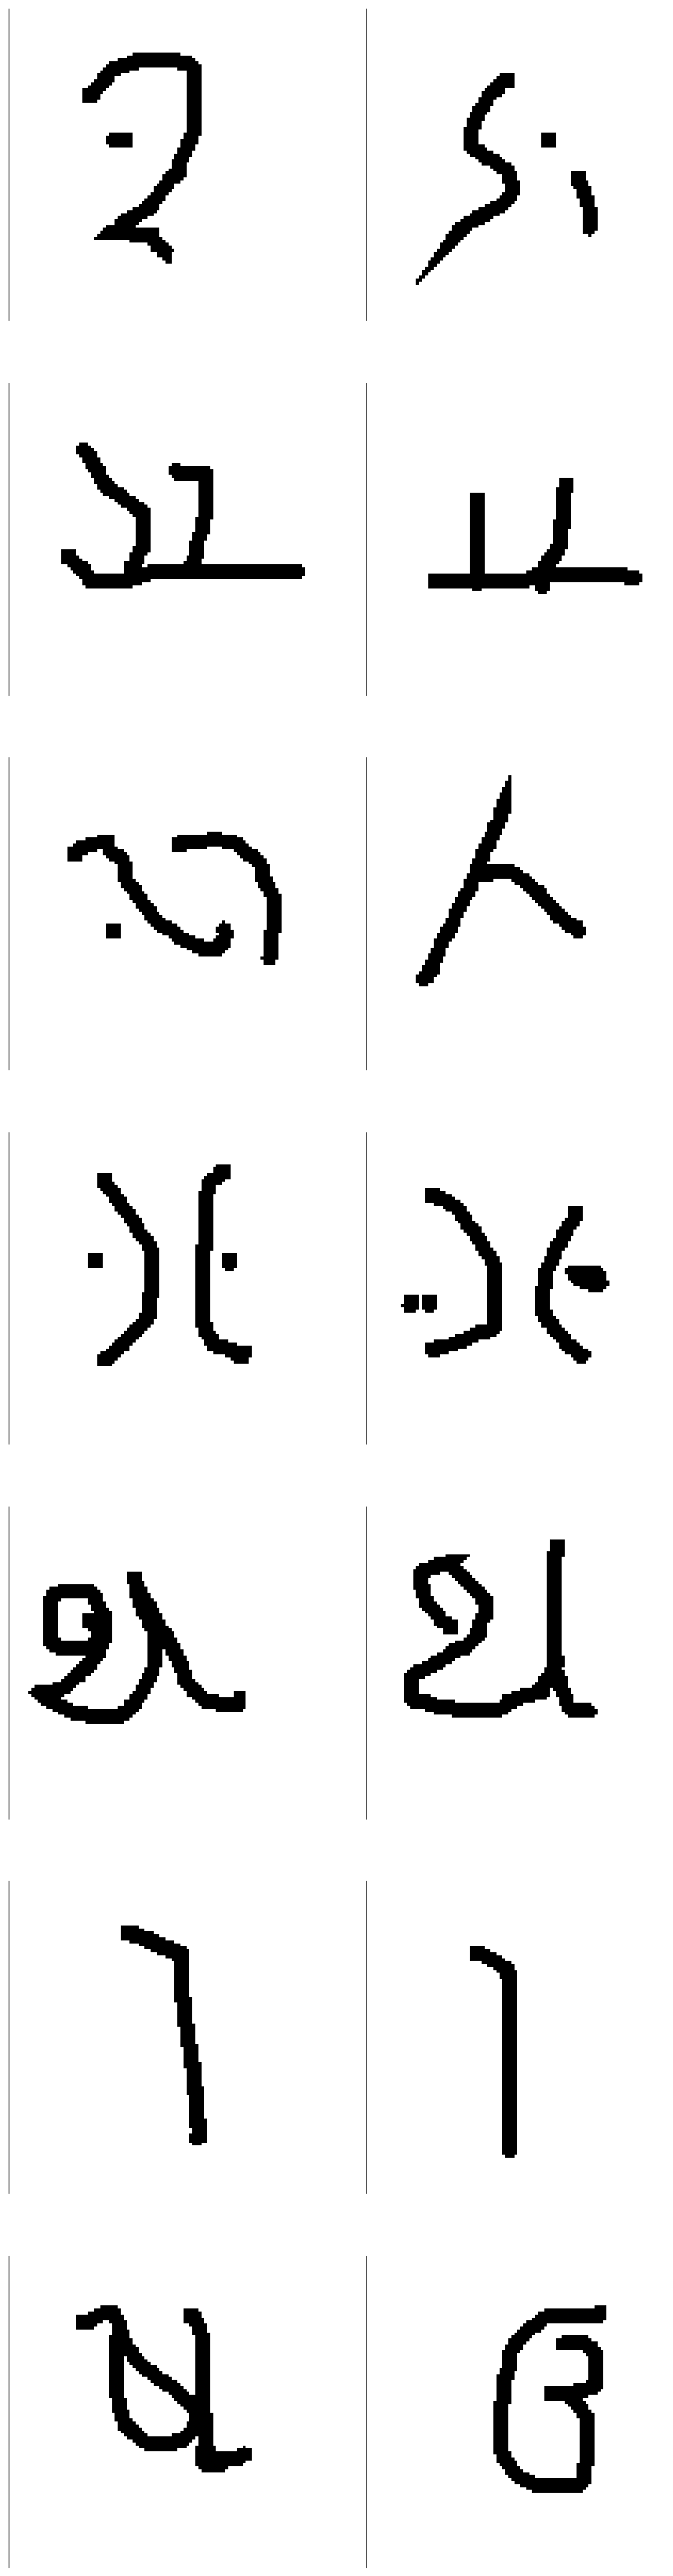

In [24]:
dim = b.shape[0]
print(d)
fig, axes = plt.subplots(dim, 2, sharey=True, figsize=(15, 60), frameon=False)
for i in range(dim):
    plot_tick_free_axis(axes[i, 0], b[i, :, :, 0])
    plot_tick_free_axis(axes[i, 1], c[i, :, :, 0])
    #axes[i, 0].spines["top"].set_visible(False)
    #axes[i, 0].axes.get_xaxis().set_ticks([])
    #axes[i, 0].axes.get_yaxis().set_ticks([])
    #axes[i, 0].spines["right"].set_visible(False)
    #axes[i, 0].spines["bottom"].set_visible(False)
    #axes[i, 0].spines["left"].set_visible(False)
    #axes[i, 0].imshow(1 - b[i, :, :, 0], cmap='Greys')
    #axes[i, 1].spines["top"].set_visible(False)
    #axes[i, 1].spines["right"].set_visible(False)
    #axes[i, 1].spines["bottom"].set_visible(False)
    #axes[i, 1].spines["left"].set_visible(False)
    #axes[i, 1].imshow(1 - c[i, :, :, 0], cmap='Greys')

In [30]:
(test_inds, train_inds), (u, v) = a.generate_one_shot(11)

In [31]:
np.concatenate((y_train[test_inds], y_train[train_inds]), axis=1)

array([['Malay_(Jawi_-_Arabic)', 'character11', '08',
        'Malay_(Jawi_-_Arabic)', 'character11', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character16', '08',
        'Malay_(Jawi_-_Arabic)', 'character16', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character29', '08',
        'Malay_(Jawi_-_Arabic)', 'character29', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character20', '08',
        'Malay_(Jawi_-_Arabic)', 'character20', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character27', '08',
        'Malay_(Jawi_-_Arabic)', 'character27', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character18', '08',
        'Malay_(Jawi_-_Arabic)', 'character18', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character26', '08',
        'Malay_(Jawi_-_Arabic)', 'character26', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character19', '08',
        'Malay_(Jawi_-_Arabic)', 'character19', '05'],
       ['Malay_(Jawi_-_Arabic)', 'character21', '08',
        'Malay_(Jawi_-_Arabic)', 'character21', '05'],
       ['Malay_(Jaw

In [32]:
y_20_shot = y_train_pd.iloc[:2500] 

In [33]:
for alphabet in y_train_pd.iloc[:2500].Alphabet.unique():
    print(alphabet + ': ', y_20_shot[y_20_shot.Alphabet == alphabet].Character.unique().shape[0])

Gujarati:  48
Korean:  40
Arcadian:  26
Malay_(Jawi_-_Arabic):  11


In [34]:
alphabet_lengths = []
for alphabet in y_train_pd.Alphabet.unique():
    characters = y_train_pd.Character[y_train_pd.Alphabet == alphabet].unique()
    alphabet_lengths.append(characters.shape[0])
print("Smallest number of characters in a training alphabet: {}".format(np.min(alphabet_lengths)))

Smallest number of characters in a training alphabet: 14


In [35]:
test_npz_file = np.load('../data/processed/test.npz')
X_test, y_test = test_npz_file['arr_0'], test_npz_file['arr_1']
y_test_pd = pd.DataFrame(data=y_test, columns=['Alphabet', 'Character', 'Drawer'])

In [36]:
alphabet_lengths = []
for alphabet in y_test_pd.Alphabet.unique():
    characters = y_test_pd.Character[y_test_pd.Alphabet == alphabet].unique()
    alphabet_lengths.append(characters.shape[0])
print("Smallest number of characters in a test alphabet: {}".format(np.min(alphabet_lengths)))

Smallest number of characters in a test alphabet: 20


In [37]:
y_train_pd.shape, y_test_pd.shape, y_train_pd.shape[0] + y_test_pd.shape[0]

((19280, 3), (13180, 3), 32460)

In [38]:
y_train_pd.Alphabet.unique().shape[0] + y_test_pd.Alphabet.unique().shape[0]

50

In [39]:
characters_in_test, characters_in_train = 0, 0
for alphabet in y_train_pd.Alphabet.unique():
    characters_in_alphabet = y_train_pd.Character[
                y_train_pd.Alphabet == alphabet
            ].unique().shape[0]
    characters_in_train += characters_in_alphabet
characters_in_train

964

In [40]:
for alphabet in y_test_pd.Alphabet.unique():
    characters_in_alphabet = y_test_pd.Character[
                y_test_pd.Alphabet == alphabet
            ].unique().shape[0]
    characters_in_test += characters_in_alphabet
characters_in_test

659

In [41]:
964 + 659

1623

In [42]:
X_test.max(), X_test.min()

(1.0, 0.0)

In [43]:
ost = OneShotGenerator(X_train[:100], y_train[:100])

In [50]:
ost.generate_one_shot()

((array([ 6, 28, 45, 76, 85]), array([ 1, 30, 42, 78, 90])),
 (    Alphabet    Character Drawer
  6   Gujarati  character42     02
  28  Gujarati  character45     02
  45  Gujarati  character11     02
  76  Gujarati  character16     02
  85  Gujarati  character29     02,     Alphabet    Character Drawer
  1   Gujarati  character42     01
  30  Gujarati  character45     01
  42  Gujarati  character11     01
  78  Gujarati  character16     01
  90  Gujarati  character29     01))

In [51]:
ost.cache[0]

((array([18, 23, 58, 60, 84]), array([16, 21, 57, 63, 81])),
 (    Alphabet    Character Drawer
  18  Gujarati  character42     18
  23  Gujarati  character45     18
  58  Gujarati  character11     18
  60  Gujarati  character16     18
  84  Gujarati  character29     18,     Alphabet    Character Drawer
  16  Gujarati  character42     20
  21  Gujarati  character45     20
  57  Gujarati  character11     20
  63  Gujarati  character16     20
  81  Gujarati  character29     20))

In [52]:
ost.current_task_number

3

In [53]:
ost.generate_one_shot(), ost.current_task_number

(((array([15, 20, 55, 62, 82]), array([ 8, 37, 47, 70, 98])),
  (    Alphabet    Character Drawer
   15  Gujarati  character42     09
   20  Gujarati  character45     09
   55  Gujarati  character11     09
   62  Gujarati  character16     09
   82  Gujarati  character29     09,     Alphabet    Character Drawer
   8   Gujarati  character42     12
   37  Gujarati  character45     12
   47  Gujarati  character11     12
   70  Gujarati  character16     12
   98  Gujarati  character29     12)),
 4)

In [54]:
y_train_pd.Drawer.iloc[:40].isin(['03', '05', '16']).values

array([False, False, False,  True, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False])

Below is an example of how to run Bayesian optimization using the GPyOpt library on cross validation score.  So we need to try to extend this basic example to maximize the validation score (maybe average over an epoch; in this case, change the default of 5 for each iteration where validation score is calculated to speed things up a bit).  

So, for a setting of parameters we need a function which will:
- Construct a model and optimizer with the given parameters.
- Train the model (here train for a maximum of 200 epochs, cutting training if validation score has consistently increased for 20 epochs or something like this.
- Save the trained model (with a name indicating the parameter values).
- Evaluate the validation score of the trained model, and output this.

Then this function will be passed to the Bayesian optimization engine and we will have saved the best model that it finds (this is important, because we don't want to re-train for a given set of parameters).     

Some other (modelling) things that might be interesting to do while this is training on the big machine:
- Get matching networks going in a colab environment so that we can train those things as well. Maybe experiment with different architectures here.  
- While both of these are training, get nearest neighbors going on raw shape-contexts (sparsified?) and see how this does...  Doesn't need to be super fast, because for any given image we are only comparing against the support set.
- Work on some graphics...  Plotting characters to illustrate the 20-shot task, etc. Also, something worth looking into would be getting tensorboard going within the optimizer so that we can look at the training process of these things and some other interesting things.
- Try to start writing the notebook and setup the final git repository so that it can be shared soon.  

In [56]:
%load_ext autoreload
%autoreload 2

import scipy
scipy.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.1.0'

In [64]:
from sklearn.preprocessing import OneHotEncoder

Init signature: OneHotEncoder(n_values='auto', categorical_features='all', dtype=<class 'numpy.float64'>, sparse=True, handle_unknown='error')
Docstring:     
Encode categorical integer features using a one-hot aka one-of-K scheme.

The input to this transformer should be a matrix of integers, denoting
the values taken on by categorical (discrete) features. The output will be
a sparse matrix where each column corresponds to one possible value of one
feature. It is assumed that input features take on values in the range
[0, n_values).

This encoding is needed for feeding categorical data to many scikit-learn
estimators, notably linear models and SVMs with the standard kernels.

Note: a one-hot encoding of y labels should use a LabelBinarizer
instead.

Read more in the :ref:`User Guide <preprocessing_categorical_features>`.

Parameters
----------
n_values : 'auto', int or array of ints
    Number of values per feature.

    - 'auto' : determine value range from training data.
    - int :

In [66]:
TestOneHot = OneHotEncoder(sparse=False)
TestOneHot.fit(
        y_train[np.random.permutation(800)[:5]][:, :2]
)

ValueError: could not convert string to float: 'Gujarati'

In [69]:
new_y_train = np.array(
    [x[0] + '_' + x[1] for x in y_train]
)

In [70]:
new_y_train[:5]

array(['Gujarati_character42', 'Gujarati_character42',
       'Gujarati_character42', 'Gujarati_character42',
       'Gujarati_character42'], dtype='<U53')

In [71]:
y_train[:5]

array([['Gujarati', 'character42', '14'],
       ['Gujarati', 'character42', '01'],
       ['Gujarati', 'character42', '15'],
       ['Gujarati', 'character42', '03'],
       ['Gujarati', 'character42', '17']], dtype='<U41')

In [72]:
test_y_values = new_y_train[np.random.permutation(800)[:50]]
TestOneHot.fit(
      test_y_values 
)

ValueError: could not convert string to float: 'Gujarati_character33'

In [73]:
from sklearn.preprocessing import MultiLabelBinarizer
MultiLabelBinarizer?

Init signature: MultiLabelBinarizer(classes=None, sparse_output=False)
Docstring:     
Transform between iterable of iterables and a multilabel format

Although a list of sets or tuples is a very intuitive format for multilabel
data, it is unwieldy to process. This transformer converts between this
intuitive format and the supported multilabel format: a (samples x classes)
binary matrix indicating the presence of a class label.

Parameters
----------
classes : array-like of shape [n_classes] (optional)
    Indicates an ordering for the class labels

sparse_output : boolean (default: False),
    Set to true if output binary array is desired in CSR sparse format

Attributes
----------
classes_ : array of labels
    A copy of the `classes` parameter where provided,
    or otherwise, the sorted set of classes found when fitting.

Examples
--------
>>> from sklearn.preprocessing import MultiLabelBinarizer
>>> mlb = MultiLabelBinarizer()
>>> mlb.fit_transform([(1, 2), (3,)])
array([[1, 1, 0]

In [89]:
TestOneHot = MultiLabelBinarizer()
TestOneHot.fit(
      [set(x) for x in np.unique(test_y_values)]
)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [90]:
TestOneHot.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'G', '_', 'a',
       'c', 'e', 'h', 'i', 'j', 'r', 't', 'u'], dtype=object)

In [82]:
np.unique(test_y_values)

array(['Gujarati_character03', 'Gujarati_character04',
       'Gujarati_character05', 'Gujarati_character11',
       'Gujarati_character12', 'Gujarati_character13',
       'Gujarati_character14', 'Gujarati_character15',
       'Gujarati_character17', 'Gujarati_character18',
       'Gujarati_character19', 'Gujarati_character21',
       'Gujarati_character22', 'Gujarati_character23',
       'Gujarati_character26', 'Gujarati_character28',
       'Gujarati_character31', 'Gujarati_character32',
       'Gujarati_character33', 'Gujarati_character35',
       'Gujarati_character36', 'Gujarati_character40',
       'Gujarati_character41', 'Gujarati_character42',
       'Gujarati_character43', 'Gujarati_character44',
       'Gujarati_character45', 'Gujarati_character46',
       'Gujarati_character47', 'Gujarati_character48'], dtype='<U53')

In [84]:
TestOneHot.transform(test_y_values[0])

KeyError: 'G'

In [91]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [97]:
labels, encodings = LabelEncoder(), OneHotEncoder(sparse=False)

encoded_ys = encodings.fit_transform(
            labels.fit_transform(test_y_values).reshape(-1, 1)
    )

In [99]:
encoded_ys[:5].shape

(5, 30)

In [1]:
import torch
import torch.nn as nn

In [2]:
x = torch.randn(5, 2)

tensor([[ 0.4633,  0.3179],
        [ 0.1690, -0.2112],
        [-0.7685,  1.0819],
        [-0.3659, -2.0365],
        [-0.7628, -0.0598]])

In [23]:
batch_size, im_dim, n_channels, n_way = 32, 105, 1, 20

x = torch.randn(batch_size, im_dim, im_dim, n_channels)

In [11]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [75]:
encoder = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=1, 
                    out_channels=64,
                    kernel_size=5
                ),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2),
                torch.nn.Dropout2d(),
                torch.nn.Conv2d(
                    in_channels=64, 
                    out_channels=128,
                    kernel_size=3
                ),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2),
                torch.nn.Dropout2d(),
                Flatten(),
                torch.nn.Linear(73728, 128) #int(128 * 3 * 3 / 4), 128)
            )

In [76]:
loss = torch.nn.CrossEntropyLoss()

In [77]:
target = torch.randn(batch_size, n_channels, im_dim, im_dim)
support_set = torch.randn(batch_size, n_way, n_channels, im_dim, im_dim)
support_set_classes = torch.randn(batch_size, n_way, n_way)

In [195]:
repeats = [1 for _ in range(128)]
repeats[0] = n_way
target_embedding = encoder(target)
support_set_embeddings = torch.stack(
        [encoder(support_set[:, i, :, :, :]) for i in range(n_way)],
    )
print(support_set_embeddings.size(), 
      target_embedding.repeat([n_way, 1, 1]).size())
similarities = cos(
            target_embedding.repeat([n_way, 1, 1]), 
            support_set_embeddings
  ).t()

torch.Size([20, 32, 128]) torch.Size([20, 32, 128])


In [197]:
similarities.shape

torch.Size([32, 20])

In [198]:
softmax = torch.nn.Softmax(dim=1)
softmax_sims = softmax(similarities)
print(softmax_sims.shape)
preds = softmax_sims.unsqueeze(1).bmm(support_set_classes).squeeze()

torch.Size([32, 20])


In [ ]:
target_classes = torch.rand(batch_size, n_way)


In [199]:
preds.shape

torch.Size([32, 20])

In [122]:
cos = nn.CosineSimilarity(dim=2)

In [28]:
cos = torch.nn.CosineSimilarity()

In [30]:
a, b = torch.randn(5, 3), torch.randn(5, 5, 3)

In [129]:
torch.nn.CrossEntropyLoss?

Init signature: torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean')
Docstring:     
This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.

It is useful when training a classification problem with `C` classes.
If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
assigning weight to each of the classes.
This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain scores for each class.

`input` has to be a Tensor of size either :math:`(minibatch, C)` or
:math:`(minibatch, C, d_1, d_2, ..., d_K)`
with :math:`K \geq 2` for the `K`-dimensional case (described later).

This criterion expects a class index (0 to `C-1`) as the
`target` for each value of a 1D tensor of size `minibatch`

The loss can be described as:

.. math::
    \text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
               

In [44]:
torch.nn.Conv2d?

Init signature: torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{in}, H, W)` and output :math:`(N, C_{out}, H_{out}, W_{out})`
can be precisely described as:

.. math::

    \begin{equation*}
    \text{out}(N_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                            \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{out_j}, k) \star \text{input}(N_i, k)
    \end{equation*},

where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:math:`H` is a height of input planes in pixels, and :math:`W` is
width in pixels.

* :attr:`stride` controls the stride for the cross-correlation, a single
  number or a tuple.

* :attr:`padding` controls the amount of implicit zero-paddings on

In [83]:
torch.stack([torch.randn(6) for i in range(2)])

tensor([[-0.4704, -0.3899,  1.9540,  0.3998,  0.4787, -0.4517],
        [-2.0221, -0.0392, -1.6051, -0.2426, -0.0655,  0.3696]])

In [90]:
a.repeat(2, 1)

tensor([[ 0.0346,  0.7960, -0.6996],
        [-0.3793,  0.1917,  0.8055],
        [ 1.2832,  1.4354, -1.6485],
        [-1.2324, -1.5399, -3.0186],
        [ 1.6849, -1.5136,  0.2635],
        [ 0.0346,  0.7960, -0.6996],
        [-0.3793,  0.1917,  0.8055],
        [ 1.2832,  1.4354, -1.6485],
        [-1.2324, -1.5399, -3.0186],
        [ 1.6849, -1.5136,  0.2635]])

In [104]:
a = torch.randn(2, 1, 2)

In [139]:
a.bmm?

Docstring:
bmm(batch2) -> Tensor

See :func:`torch.bmm`
Type:      builtin_function_or_method


In [140]:
torch.bmm?

Docstring:
bmm(batch1, batch2, out=None) -> Tensor

Performs a batch matrix-matrix product of matrices stored in :attr:`batch1`
and :attr:`batch2`.

:attr:`batch1` and :attr:`batch2` must be 3-D tensors each containing
the same number of matrices.

If :attr:`batch1` is a :math:`(b \times n \times m)` tensor, :attr:`batch2` is a
:math:`(b \times m \times p)` tensor, :attr:`out` will be a
:math:`(b \times n \times p)` tensor.

.. math::
    out_i = batch1_i \mathbin{@} batch2_i

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
          For broadcasting matrix products, see :func:`torch.matmul`.

Args:
    batch1 (Tensor): the first batch of matrices to be multiplied
    batch2 (Tensor): the second batch of matrices to be multiplied
    out (Tensor, optional): the output tensor

Example::

    >>> batch1 = torch.randn(10, 3, 4)
    >>> batch2 = torch.randn(10, 4, 5)
    >>> res = torch.bmm(batch1, batch2)
    >>> res.size()
    torch.Size([10, 3, 5])
Type:     

In [142]:
torch.unsqueeze?

Docstring:
unsqueeze(input, dim, out=None) -> Tensor

Returns a new tensor with a dimension of size one inserted at the
specified position.

The returned tensor shares the same underlying data with this tensor.

A :attr:`dim` value within the range ``[-input.dim() - 1, input.dim() + 1)``
can be used. Negative :attr:`dim` will correspond to :meth:`unsqueeze`
applied at :attr:`dim` = ``dim + input.dim() + 1``.

Args:
    input (Tensor): the input tensor
    dim (int): the index at which to insert the singleton dimension
    out (Tensor, optional): the output tensor

Example::

    >>> x = torch.tensor([1, 2, 3, 4])
    >>> torch.unsqueeze(x, 0)
    tensor([[ 1,  2,  3,  4]])
    >>> torch.unsqueeze(x, 1)
    tensor([[ 1],
            [ 2],
            [ 3],
            [ 4]])
Type:      builtin_function_or_method


In [144]:
u = torch.randn(5).unsqueeze(1)

In [147]:
u.bmm(torch.randn(5, 1))

RuntimeError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [150]:
u * torch.randn(5, 1)

tensor([[-0.1046],
        [ 0.0557],
        [-0.5311],
        [-0.1422],
        [ 0.3786]])

In [151]:
torch.randn(1, 5).bmm(u)

RuntimeError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [152]:
u

tensor([[-0.5765],
        [-0.2798],
        [ 0.7478],
        [-0.5178],
        [ 0.6074]])

In [153]:
torch.randn(1, 5)

tensor([[-0.4195, -0.1233, -0.1362,  1.0434,  0.8230]])

In [155]:
torch.bmm?

Docstring:
bmm(batch1, batch2, out=None) -> Tensor

Performs a batch matrix-matrix product of matrices stored in :attr:`batch1`
and :attr:`batch2`.

:attr:`batch1` and :attr:`batch2` must be 3-D tensors each containing
the same number of matrices.

If :attr:`batch1` is a :math:`(b \times n \times m)` tensor, :attr:`batch2` is a
:math:`(b \times m \times p)` tensor, :attr:`out` will be a
:math:`(b \times n \times p)` tensor.

.. math::
    out_i = batch1_i \mathbin{@} batch2_i

.. note:: This function does not :ref:`broadcast <broadcasting-semantics>`.
          For broadcasting matrix products, see :func:`torch.matmul`.

Args:
    batch1 (Tensor): the first batch of matrices to be multiplied
    batch2 (Tensor): the second batch of matrices to be multiplied
    out (Tensor, optional): the output tensor

Example::

    >>> batch1 = torch.randn(10, 3, 4)
    >>> batch2 = torch.randn(10, 4, 5)
    >>> res = torch.bmm(batch1, batch2)
    >>> res.size()
    torch.Size([10, 3, 5])
Type:     

In [159]:
a, b = torch.randn(5, 2), torch.randn(5, 2, 3)

In [172]:
a.unsqueeze(1).bmm(b).squeeze()

tensor([[ 0.2140, -1.8143, -1.3858],
        [ 0.5442,  0.5898, -0.4103],
        [-1.1018,  2.6175,  2.2155],
        [ 1.2661,  0.5904, -2.2937],
        [ 0.1823, -0.1176, -0.5553]])

In [180]:
a[0, :].data.numpy().dot([-0.1393, -0.0603])

0.2139085930645466

In [174]:
a[0, :].dot(torch.tensor([-0.1393, -0.0603]))

tensor(36893488147419103232.)

In [181]:
b

tensor([[[-0.1393,  0.7030,  0.4449],
         [-0.0603,  1.5893,  1.4215]],

        [[-2.4186,  0.5901,  0.1137],
         [-0.5182, -0.4702,  0.3420]],

        [[-0.9674, -1.9657, -2.5030],
         [ 2.0719,  0.2152,  1.1932]],

        [[-0.8588,  0.2411,  0.8915],
         [ 0.1181,  0.4073, -0.5786]],

        [[-0.7648,  0.4800,  1.4808],
         [-0.5403,  0.3096, -0.8365]]])

In [183]:
a, a[0, :]

(tensor([[-1.2881, -0.5718],
         [ 0.0345, -1.2112],
         [-1.4646, -1.2157],
         [-1.1789,  2.1477],
         [-0.3143,  0.1075]]), tensor([-1.2881, -0.5718]))

In [187]:
a.unsqueeze(1)

tensor([[[-1.2881, -0.5718]],

        [[ 0.0345, -1.2112]],

        [[-1.4646, -1.2157]],

        [[-1.1789,  2.1477]],

        [[-0.3143,  0.1075]]])

In [185]:
a.shape

torch.Size([5, 2])

In [188]:
b.shape

torch.Size([5, 2, 3])

In [189]:
a.unsqueeze(1).bmm(b).shape

torch.Size([5, 1, 3])

In [200]:
import torch.optim as optim

In [201]:
optim.Adam?

Init signature: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
Docstring:     
Implements Adam algorithm.

It has been proposed in `Adam: A Method for Stochastic Optimization`_.

Arguments:
    params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
    lr (float, optional): learning rate (default: 1e-3)
    betas (Tuple[float, float], optional): coefficients used for computing
        running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional): term added to the denominator to improve
        numerical stability (default: 1e-8)
    weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    amsgrad (boolean, optional): whether to use the AMSGrad variant of this
        algorithm from the paper `On the Convergence of Adam and Beyond`_

.. _Adam\: A Method for Stochastic Optimization:
    https://arxiv.org/abs/1412.6980
.. _On the Convergence of Adam and 

In [203]:
from torch.utils.data import Dataset, DataLoader

In [204]:
Dataset?

Init signature: Dataset()
Docstring:     
An abstract class representing a Dataset.

All other datasets should subclass it. All subclasses should override
``__len__``, that provides the size of the dataset, and ``__getitem__``,
supporting integer indexing in range from 0 to len(self) exclusive.
File:           /anaconda3/lib/python3.6/site-packages/torch/utils/data/dataset.py
Type:           type


In [205]:
DataLoader?

Init signature: DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate at 0x10e723048>, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides
single- or multi-process iterators over the dataset.

Arguments:
    dataset (Dataset): dataset from which to load the data.
    batch_size (int, optional): how many samples per batch to load
        (default: 1).
    shuffle (bool, optional): set to ``True`` to have the data reshuffled
        at every epoch (default: False).
    sampler (Sampler, optional): defines the strategy to draw samples from
        the dataset. If specified, ``shuffle`` must be False.
    batch_sampler (Sampler, optional): like sampler, but returns a batch of
        indices at a time. Mutually exclusive with batch_size, shuffle,
        sampler, and drop_last.
    num_workers (int, optional): how many s

In [206]:
from torch.utils.data import dataset

In [207]:
dataset?

Type:        module
String form: <module 'torch.utils.data.dataset' from '/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataset.py'>
File:        /anaconda3/lib/python3.6/site-packages/torch/utils/data/dataset.py
Docstring:   <no docstring>


In [208]:
dataset.Dataset?

Init signature: dataset.Dataset()
Docstring:     
An abstract class representing a Dataset.

All other datasets should subclass it. All subclasses should override
``__len__``, that provides the size of the dataset, and ``__getitem__``,
supporting integer indexing in range from 0 to len(self) exclusive.
File:           /anaconda3/lib/python3.6/site-packages/torch/utils/data/dataset.py
Type:           type


In [6]:
import os

In [211]:
!pwd

/Users/mkoudstaal/Documents/Projects/one-shot/notebooks


In [2]:
os.walk?

Signature: os.walk(top, topdown=True, onerror=None, followlinks=False)
Docstring:
Directory tree generator.

For each directory in the directory tree rooted at top (including top
itself, but excluding '.' and '..'), yields a 3-tuple

    dirpath, dirnames, filenames

dirpath is a string, the path to the directory.  dirnames is a list of
the names of the subdirectories in dirpath (excluding '.' and '..').
filenames is a list of the names of the non-directory files in dirpath.
Note that the names in the lists are just names, with no path components.
To get a full path (which begins with top) to a file or directory in
dirpath, do os.path.join(dirpath, name).

If optional arg 'topdown' is true or not specified, the triple for a
directory is generated before the triples for any of its subdirectories
(directories are generated top down).  If topdown is false, the triple
for a directory is generated after the triples for all of its
subdirectories (directories are generated bottom up).

When t

In [7]:
os.getcwd()

'/Users/mkoudstaal/Documents/Projects/one-shot/notebooks'

In [10]:
for (root, dirs, files) in os.walk('/Users/mkoudstaal/Documents/Projects/one-shot/src'):
    print(root)
    print(dirs)
    print(files)

/Users/mkoudstaal/Documents/Projects/one-shot/src
['visualization', 'features', 'models', 'data']
['__init__.py']
/Users/mkoudstaal/Documents/Projects/one-shot/src/visualization
[]
['.gitkeep', '__init__.py', 'visualize.py']
/Users/mkoudstaal/Documents/Projects/one-shot/src/features
[]
['.gitkeep', 'build_features.py', '__init__.py']
/Users/mkoudstaal/Documents/Projects/one-shot/src/models
[]
['train_model.py', '.gitkeep', '__init__.py', 'predict_model.py']
/Users/mkoudstaal/Documents/Projects/one-shot/src/data
[]
['.DS_Store', '.gitkeep', '__init__.py', 'make_dataset.py', 'data_utils.py']
